# PL波長の予測

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.2)  # seabornスタイル適用
import numpy as np
import pandas as pd

from sklearn.cross_decomposition import PLSRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb

import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

/opt/conda/envs/mol-regression-env/lib/python3.9/site-packages/xgboost/compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# データ読み込み、学習データ＋未知のデータ
data = pd.read_csv('material_data.csv', index_col=0)
# rdkit
des_rdkit = pd.read_csv('descriptor_rdkit.csv', index_col=0)
# FP
fingerprint_df = pd.read_csv('morganFP.csv', index_col=0)
# mordred, 2次元
des_mordred_2d = pd.read_csv('descriptor_mordred_2d.csv', index_col=0)
# mordred, 3次元
des_mordred_3d = pd.read_csv('descriptor_mordred_3d.csv', index_col=0)

data.shape, des_rdkit.shape, fingerprint_df.shape, des_mordred_2d.shape, des_mordred_3d.shape

((233, 3), (233, 217), (233, 2048), (233, 1158), (233, 1826))

## rdkit

In [3]:
# 結合
dataset = pd.concat([data.reset_index(), des_rdkit.reset_index(drop=True)], axis=1)

# index降り直し
dataset = dataset.set_index('Material')

dataset.head()

,SMILES,Type,PL,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
Material,,,,,,,,,,,,,,,,,,,,,
BTD1,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=CC=...,BTD,533.0,4.814638,4.814638,0.031632,-0.031632,0.216906,16.205128,520.701,...,0,0,0,0,0,0,0,0,0,0
BTD2,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(C...,BTD,540.0,5.006910,5.006910,0.211411,-0.211411,0.159110,14.233766,1003.287,...,0,0,0,0,0,0,0,0,0,0
BTD3,CC1(C)C2=C(C=CC(C3=CC(N4C(C=CC=C5)=C5C6=C4C=CC...,BTD,538.0,5.006077,5.006077,0.214711,-0.214711,0.166391,13.922078,1003.287,...,0,0,0,0,0,0,0,0,0,0
BTD4,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(N...,BTD,584.0,4.969197,4.969197,0.216216,-0.216216,0.152454,14.153846,855.123,...,0,0,0,0,0,0,0,0,0,0
BTD5,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(C...,BTD,540.0,5.020606,5.020606,0.232982,-0.232982,0.159110,14.233766,1003.287,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# 学習データのみを抽出
dataset_train = dataset.dropna(subset='PL')
# TypeとSMILESを消す
dataset_train = dataset_train.drop(['SMILES', 'Type'], axis=1)

dataset_train.shape

(228, 218)

In [5]:
# infをNaNに置き換え
dataset_train = dataset_train.replace(np.inf, np.nan).fillna(np.nan)
dataset_train_2 = dataset_train.drop(dataset_train.columns[dataset_train.isnull().any()], axis=1)

# 標準偏差が0の記述を削除
dataset_train_3 = dataset_train_2.drop(dataset_train_2.columns[dataset_train_2.std() == 0], axis=1)

dataset_train_2.shape, dataset_train_3.shape

((228, 218), (228, 152))

In [6]:
# 欠損値の確認
dataset_train_3.isnull().sum().value_counts()

0    152
Name: count, dtype: int64

In [7]:
# 目的変数と説明変数に分ける
y = dataset_train_3['PL']
X = dataset_train_3.drop('PL', axis=1)

# Hold-out
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1234)

In [8]:
# 標準化
std = StandardScaler()
autoscaled_X_train = std.fit_transform(X_train)
autoscaled_X_val = std.transform(X_val)

# pandas形式に
autoscaled_X_train = pd.DataFrame(autoscaled_X_train, columns=X_train.columns, index=X_train.index)
autoscaled_X_val = pd.DataFrame(autoscaled_X_val, columns=X_val.columns, index=X_val.index)

In [9]:
# 標準化後、欠損値がないか再度確認
print(autoscaled_X_train.isnull().sum().value_counts())
print(autoscaled_X_val.isnull().sum().value_counts())

0    151
Name: count, dtype: int64
0    151
Name: count, dtype: int64


In [10]:
# 可視化の関数

def yyplot(train_df, test_df):
    # ===== 指標の計算 =====
    rmse_tr = np.sqrt(mean_squared_error(train_df['true'], train_df['pred']))
    r2_tr = r2_score(train_df['true'], train_df['pred'])
    mae_tr = mean_absolute_error(train_df['true'], train_df['pred'])

    rmse_te = np.sqrt(mean_squared_error(test_df['true'], test_df['pred']))
    r2_te = r2_score(test_df['true'], test_df['pred'])
    mae_te = mean_absolute_error(test_df['true'], test_df['pred'])

    # ===== グラフ作成 =====
    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)

    # 散布図
    ax.scatter(train_df['true'], train_df['pred'], c='red', label='Train', alpha=0.6)
    ax.scatter(test_df['true'], test_df['pred'], c='blue', label='Val', alpha=0.6)

    # 理想線
    all_true = pd.concat([train_df['true'], test_df['true']])
    min_val = all_true.min()
    max_val = all_true.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

    # 軸ラベル
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')

    # 範囲調整
    margin = (max_val - min_val) * 0.05
    ax.set_xlim(min_val - margin, max_val + margin)
    ax.set_ylim(min_val - margin, max_val + margin)

    # 評価値表示（右上）
    ax.text(0.05, 0.95, f'Train RMSE = {rmse_tr:.2f}\nTrain MAE  = {mae_tr:.2f}\nTrain R²    = {r2_tr:.2f}',
            transform=ax.transAxes, fontsize=11, color='red', verticalalignment='top')
    ax.text(0.05, 0.80, f'Val  RMSE = {rmse_te:.2f}\nVal  MAE  = {mae_te:.2f}\nVal  R²    = {r2_te:.2f}',
            transform=ax.transAxes, fontsize=11, color='blue', verticalalignment='top')

    # 凡例
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


### PLS

1 -5.15443606468478e+26
2 -9.917334305721993e+27
3 -6.4007965903870575e+28
4 -1.0802522927072077e+29
5 -4.958446997273563e+28
6 -4.501189555957104e+28
7 -7.371236845651091e+27
8 -1.1033956128324942e+26
9 -1.5051336078743033e+25
10 -2.7891479797093907e+28
11 -1.0987348293573476e+29
12 -1.5539570476147002e+29
13 -1.1677551269997041e+29
14 -8.130010806936802e+28
15 -6.828498786286101e+28
16 -5.47284945011195e+28
17 -5.985156932803303e+28
18 -6.726459109931548e+28
19 -5.96179772324911e+28
20 -8.786499530988388e+27
21 -6.85637003303132e+26
22 -2.364569547093968e+28
23 -1.9497023429667754e+28
24 -5.700162193545035e+27
25 -3.657353929447273e+27
26 -9.018778554059445e+27
27 -2.945263145762505e+26
28 -2.6911600471845107e+27
29 -1.3714929154236418e+28
30 -2.7574726323761e+28
31 -3.6078218777094515e+28
32 -5.101189595478303e+28
33 -4.6424998198378754e+28
34 -3.900193683192943e+27
35 -8.655616442575362e+27
36 -4.279159036539339e+28
37 -3.171861632670079e+28
38 -1.8719632662325173e+27
39 -4.0946535

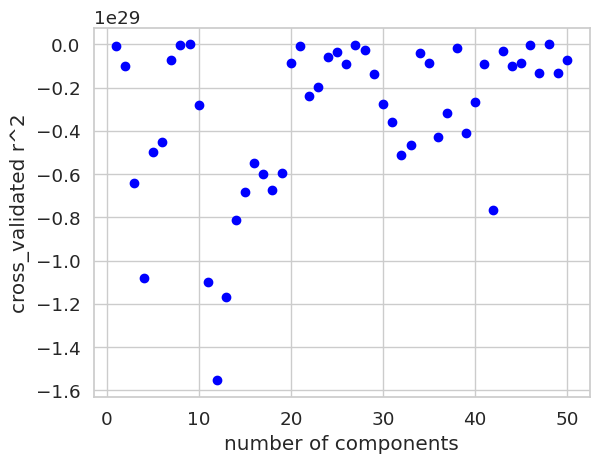

In [11]:
# CVによる成分数の最適化

# 使用する主成分の最大数。説明変数の数より小さい必要があります
max_number_of_principal_components = 50

# N-fold CV の N
fold_number = 5  

# 空のリストを用意
components = []
r2_in_cv_all = []

for component in range(1, max_number_of_principal_components+1):
    # PLS
    model = PLSRegression(n_components=component)
    # CV
    estimated_y_cv = cross_val_predict(model, autoscaled_X_train, y_train,
                                       cv=fold_number)
    estimated_y_cv = pd.DataFrame(estimated_y_cv)
    
    # r2を計算
    r2_in_cv = r2_score(y_train, estimated_y_cv)
    
    # 成分数とr2を表示
    print(component, r2_in_cv)
    
    # r2とcomponentを追加
    components.append(component)
    r2_in_cv_all.append(r2_in_cv)

# 成分数毎のr^2をプロットし、CV後のr^2が最大の時を、最適成分数として抽出

plt.scatter(components, r2_in_cv_all, c='blue')
plt.xlabel('number of components')
plt.ylabel('cross_validated r^2')
plt.show()

In [12]:
optimal_component_number = components[r2_in_cv_all.index(max(r2_in_cv_all))]

print('最適な主成分数 :', optimal_component_number)

最適な主成分数 : 48


- 機能していない

### RandomForest

In [13]:
# デフォルト
model_rf = RandomForestRegressor(random_state=1234)

# モデル構築、予測
model_rf.fit(autoscaled_X_train, y_train)
y_train_pred = model_rf.predict(autoscaled_X_train)
y_val_pred = model_rf.predict(autoscaled_X_val)

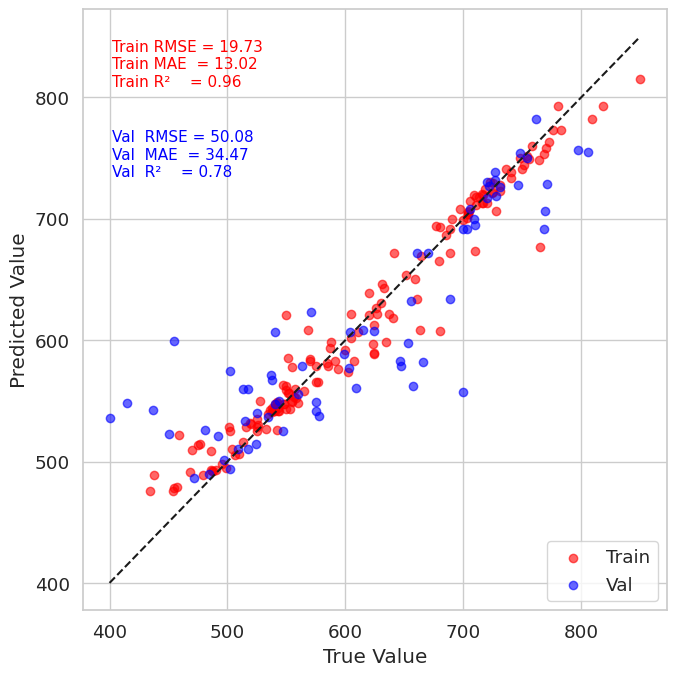

In [14]:
# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

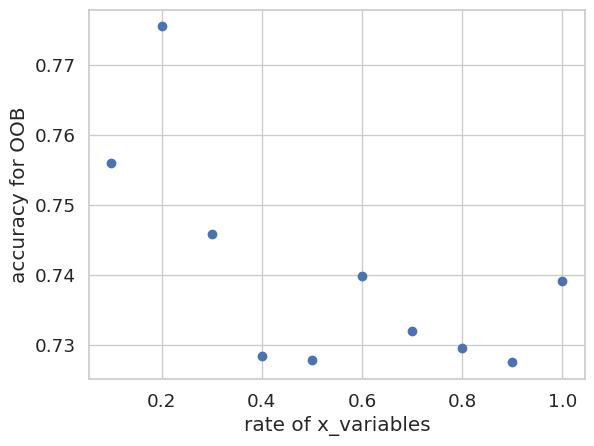


OOBで最適化された説明変数の割合： 0.2


In [15]:
# Out of Bagを使ってモデルが改良できるか
# 1つの決定木における説明変数の数の割合の候補
rf_x_variables_rates = np.arange(1, 11, dtype=float) / 10

r2_oob = []

for index, x_variables_rate in enumerate(rf_x_variables_rates):
    # 検証用モデル構築
    model_in_validation = RandomForestRegressor(n_estimators=100,
                                                 # np.ceilは切り上げ関数で整数にしている。
                                                 max_features=int(max(np.ceil(X_train.shape[1]*x_variables_rate), 1)),
                                                 oob_score=True, random_state=1234)
    model_in_validation.fit(autoscaled_X_train, y_train)

    # 空箱にr2を追加
    r2_oob.append(model_in_validation.oob_score_)

# 可視化
plt.scatter(rf_x_variables_rates, r2_oob)
plt.xlabel('rate of x_variables')
plt.ylabel('accuracy for OOB')
plt.show()

# 最適な説明変数の割合を取得
optimal_x_variables_rate = rf_x_variables_rates[r2_oob.index(max(r2_oob))]

print('\nOOBで最適化された説明変数の割合：', optimal_x_variables_rate)

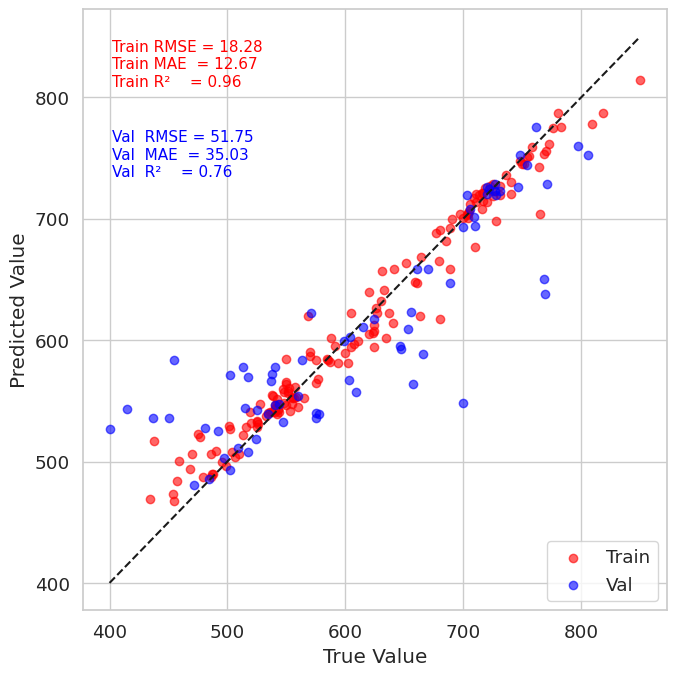

In [16]:
# RF_OOBモデル構築
model_rf_oob = RandomForestRegressor(max_features=int(max(np.ceil(autoscaled_X_train.shape[1]*optimal_x_variables_rate), 1)),
                                     oob_score=True)
# 学習
model_rf_oob.fit(autoscaled_X_train, y_train)
# 予測
y_train_pred = model_rf_oob.predict(autoscaled_X_train)
y_val_pred = model_rf_oob.predict(autoscaled_X_val)

# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

/tmp/ipykernel_1660/1798592255.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_rf['feature'][:10],


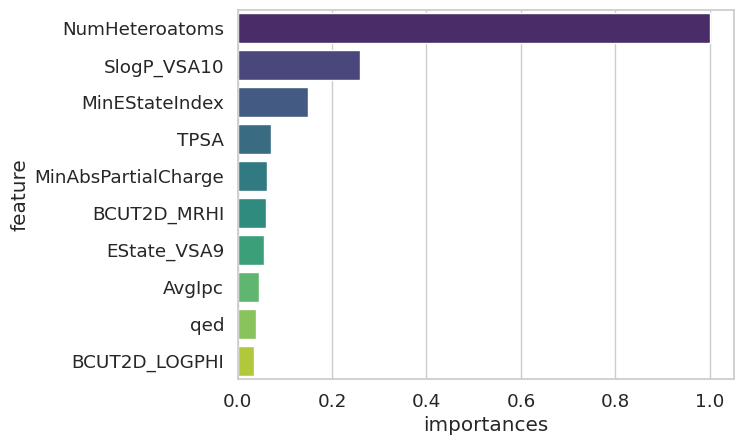

In [17]:
# 特徴量重要度を出す
feature_map_rf = pd.DataFrame([X_train.columns, model_rf.feature_importances_]).T
feature_map_rf.columns = ['feature', 'importances']

# 降順に
feature_map_rf = feature_map_rf.sort_values('importances', ascending=False)

# 規格化
feature_map_rf['importances'] = feature_map_rf['importances'] / feature_map_rf['importances'].max()

# 可視化
sns.barplot(y=feature_map_rf['feature'][:10],
            x=feature_map_rf['importances'][:10],
            palette='viridis')
plt.show()

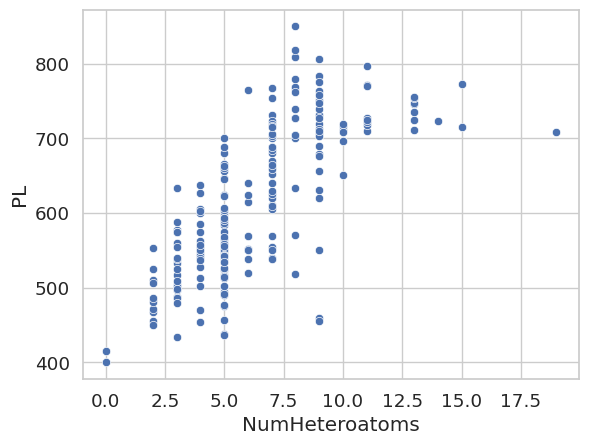

In [18]:
# 予測に役立った説明変数と目的関数の関係をplot
sns.scatterplot(x='NumHeteroatoms',
                y='PL',
                data=dataset_train)

plt.show()

### XGBoost

[0]	validation_0-rmse:439.81403
[1]	validation_0-rmse:317.45311
[2]	validation_0-rmse:229.72389
[3]	validation_0-rmse:170.80386
[4]	validation_0-rmse:127.48579
[5]	validation_0-rmse:99.65453
[6]	validation_0-rmse:81.07073
[7]	validation_0-rmse:69.13368
[8]	validation_0-rmse:60.23570
[9]	validation_0-rmse:55.63613
[10]	validation_0-rmse:53.69462
[11]	validation_0-rmse:51.99078
[12]	validation_0-rmse:50.76989
[13]	validation_0-rmse:50.20529
[14]	validation_0-rmse:49.49150
[15]	validation_0-rmse:49.19567
[16]	validation_0-rmse:49.27196
[17]	validation_0-rmse:48.96763
[18]	validation_0-rmse:48.89196
[19]	validation_0-rmse:49.19679
[20]	validation_0-rmse:49.27681
[21]	validation_0-rmse:49.11187
[22]	validation_0-rmse:49.17545
[23]	validation_0-rmse:49.21146
[24]	validation_0-rmse:49.28435
[25]	validation_0-rmse:49.29622
[26]	validation_0-rmse:49.27774
[27]	validation_0-rmse:49.32188
[28]	validation_0-rmse:49.28126
[29]	validation_0-rmse:49.31250
[30]	validation_0-rmse:49.30968
[31]	validati

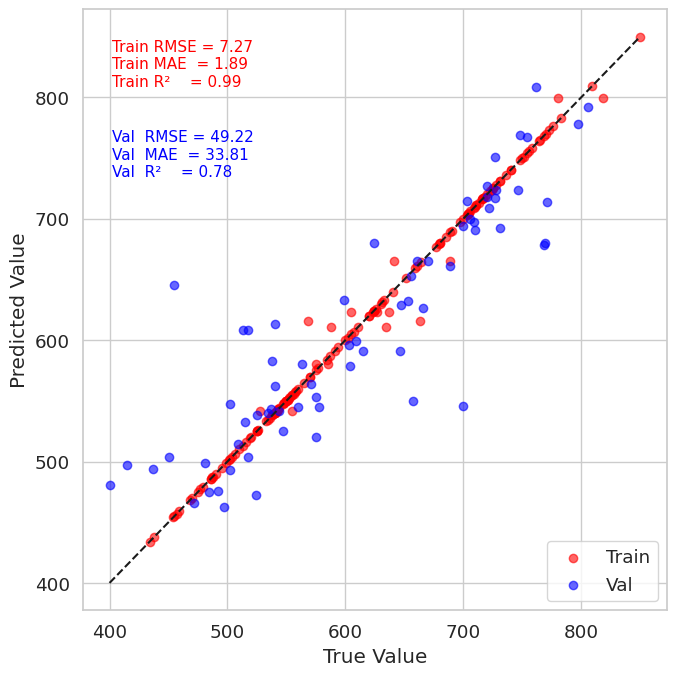

In [19]:
# デフォルトXGB
model_xgb = xgb.XGBRegressor(random_state=1234)

# テストデータの組
eval_set = [(autoscaled_X_val, y_val)]

# モデル学習
model_xgb.fit(autoscaled_X_train, y_train, eval_set=eval_set)

# 予測
y_train_pred = model_xgb.predict(autoscaled_X_train)
y_val_pred = model_xgb.predict(autoscaled_X_val)

# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

### XGBoost+optuna

In [20]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'tree_method': 'hist',  # CPUで高速にする場合
    }

    # テストデータの組
    eval_set = [(autoscaled_X_val, y_val)]

    model_xgb_optuna = xgb.XGBRegressor(**param)

    model_xgb_optuna.fit(autoscaled_X_train, y_train, eval_set=eval_set, verbose=0)

    y_pred = model_xgb_optuna.predict(autoscaled_X_val)
    r2 = r2_score(y_val, y_pred)

    return r2  # 最大化したいのでそのまま返す

In [21]:
# 学習
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # 試行回数や時間は任意

[I 2025-06-24 20:11:31,393] A new study created in memory with name: no-name-bff12cfb-105c-42a6-a77e-194213d390fe
[I 2025-06-24 20:11:31,913] Trial 0 finished with value: 0.8059017654078278 and parameters: {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.19019163764355987, 'subsample': 0.5137284598878828, 'colsample_bytree': 0.5768572994090893, 'reg_alpha': 0.06467914940579103, 'reg_lambda': 0.14411875781652486}. Best is trial 0 with value: 0.8059017654078278.
[I 2025-06-24 20:11:32,187] Trial 1 finished with value: 0.019929547160101535 and parameters: {'n_estimators': 162, 'max_depth': 8, 'learning_rate': 0.01272202760964235, 'subsample': 0.7246974334299191, 'colsample_bytree': 0.7745682951117686, 'reg_alpha': 0.11966195092940882, 'reg_lambda': 1.2171797920605762}. Best is trial 0 with value: 0.8059017654078278.
[I 2025-06-24 20:11:32,763] Trial 2 finished with value: 0.41780321041657464 and parameters: {'n_estimators': 228, 'max_depth': 5, 'learning_rate': 0.01019553571377303

In [22]:
# ハイパーパラメータ・スコアの確認
print("Best trial:")
trial = study.best_trial

print(f"  R²: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  R²: 0.8599
  Params:
    n_estimators: 300
    max_depth: 5
    learning_rate: 0.024985529394484465
    subsample: 0.8877870322505842
    colsample_bytree: 0.6973741879463456
    reg_alpha: 7.405410308074901
    reg_lambda: 3.550116629207211


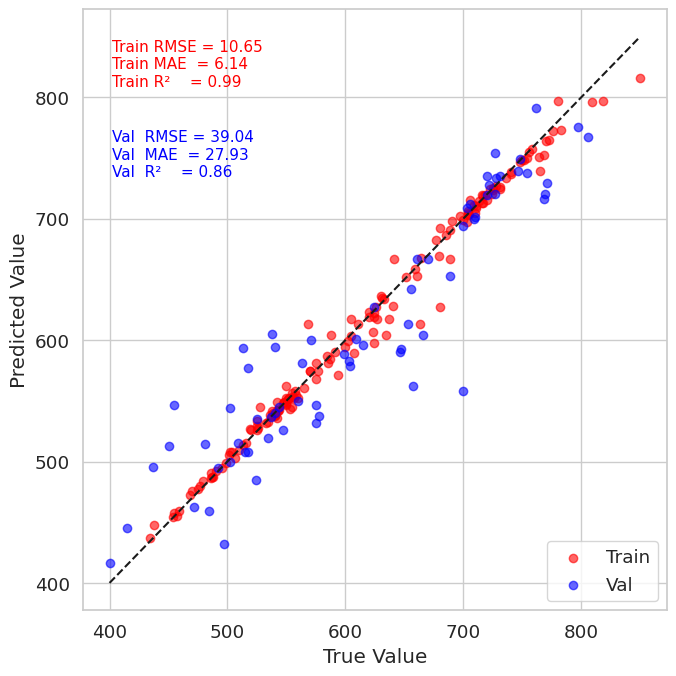

In [23]:
# 再学習
best_params = trial.params
model_xgb_best = xgb.XGBRegressor(**best_params)
model_xgb_best.fit(autoscaled_X_train, y_train, eval_set=eval_set, verbose=0)

# 予測
y_train_pred = model_xgb_best.predict(autoscaled_X_train)
y_val_pred = model_xgb_best.predict(autoscaled_X_val)

# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

/tmp/ipykernel_1660/1669432058.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_xgb['feature'][:10],


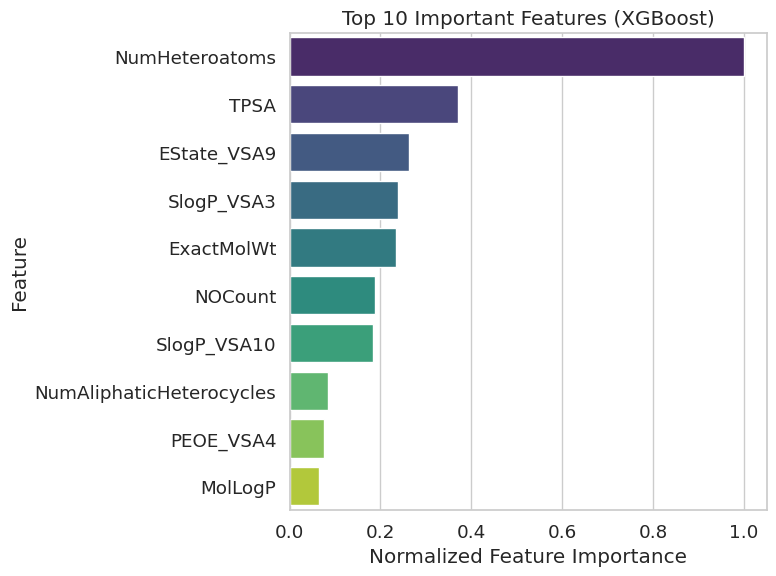

In [24]:
# 特徴量重要度を取得
feature_map_xgb = pd.DataFrame([X_train.columns, model_xgb_best.feature_importances_]).T
feature_map_xgb.columns = ['feature', 'importances']

# 降順に並べ替え
feature_map_xgb = feature_map_xgb.sort_values('importances', ascending=False)

# 規格化（最大値で割る）
feature_map_xgb['importances'] = feature_map_xgb['importances'] / feature_map_xgb['importances'].max()

# 上位10個の特徴量を可視化
plt.figure(figsize=(8, 6))
sns.barplot(y=feature_map_xgb['feature'][:10],
            x=feature_map_xgb['importances'][:10],
            palette='viridis')
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (XGBoost)')
plt.tight_layout()
plt.show()


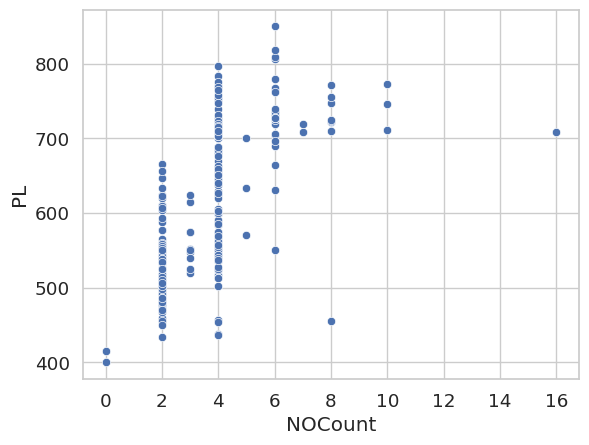

In [25]:
# 予測に役立った説明変数と目的関数の関係をplot
sns.scatterplot(x='NOCount',
                y='PL',
                data=dataset_train)

plt.show()

### LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3889
[LightGBM] [Info] Number of data points in the train set: 159, number of used features: 123
[LightGBM] [Info] Start training from score 613.924528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

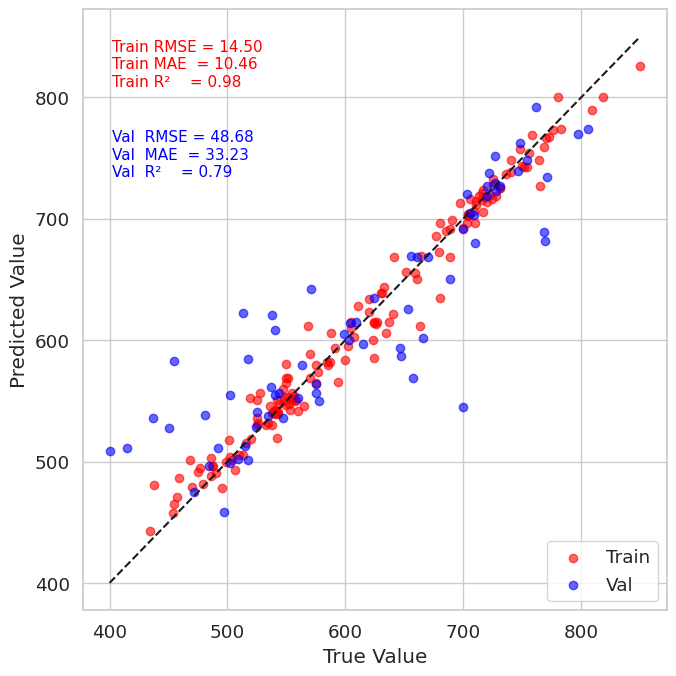

In [26]:
# デフォルト
model_lgb = lgb.LGBMRegressor(random_state=1234)

eval_set = [(autoscaled_X_val, y_val)]

# モデル学習
model_lgb.fit(autoscaled_X_train, y_train, eval_set=eval_set)

# 予測
y_train_pred = model_lgb.predict(autoscaled_X_train)
y_val_pred = model_lgb.predict(autoscaled_X_val)

# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

### LightGBM+Optuna

In [27]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',  # LightGBMが内部で使う評価指標
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'verbosity': -1,
    }

    model = lgb.LGBMRegressor(**param)
    eval_set = [(autoscaled_X_val, y_val)]
    model.fit(autoscaled_X_train, y_train, eval_set=eval_set)

    y_pred = model.predict(autoscaled_X_val)
    return r2_score(y_val, y_pred)

# 最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # 50試行 or 600秒

# 結果表示
print("Best trial:")
print(f"  R²: {study.best_trial.value:.4f}")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-24 20:12:08,592] A new study created in memory with name: no-name-0355d980-37c0-4d05-9dc3-9c95bd7037e2
[I 2025-06-24 20:12:08,651] Trial 0 finished with value: 0.759029010343566 and parameters: {'n_estimators': 139, 'learning_rate': 0.03187715094087627, 'max_depth': 9, 'num_leaves': 15, 'subsample': 0.6891091895848899, 'colsample_bytree': 0.724354887588565, 'reg_alpha': 2.429969044325753e-07, 'reg_lambda': 0.001592825005240535}. Best is trial 0 with value: 0.759029010343566.
[I 2025-06-24 20:12:08,679] Trial 1 finished with value: 0.788091315972441 and parameters: {'n_estimators': 65, 'learning_rate': 0.15336283766781905, 'max_depth': 7, 'num_leaves': 27, 'subsample': 0.9014910384264136, 'colsample_bytree': 0.9180196304830287, 'reg_alpha': 0.003798933199503473, 'reg_lambda': 1.4218252126068539e-06}. Best is trial 1 with value: 0.788091315972441.
[I 2025-06-24 20:12:08,826] Trial 2 finished with value: 0.6622359765846921 and parameters: {'n_estimators': 147, 'learning_rate': 

Best trial:
  R²: 0.8079
    n_estimators: 280
    learning_rate: 0.25719184459073285
    max_depth: 8
    num_leaves: 86
    subsample: 0.9478501697340002
    colsample_bytree: 0.7544852521060497
    reg_alpha: 0.0037627699143834245
    reg_lambda: 0.0009512560745593751


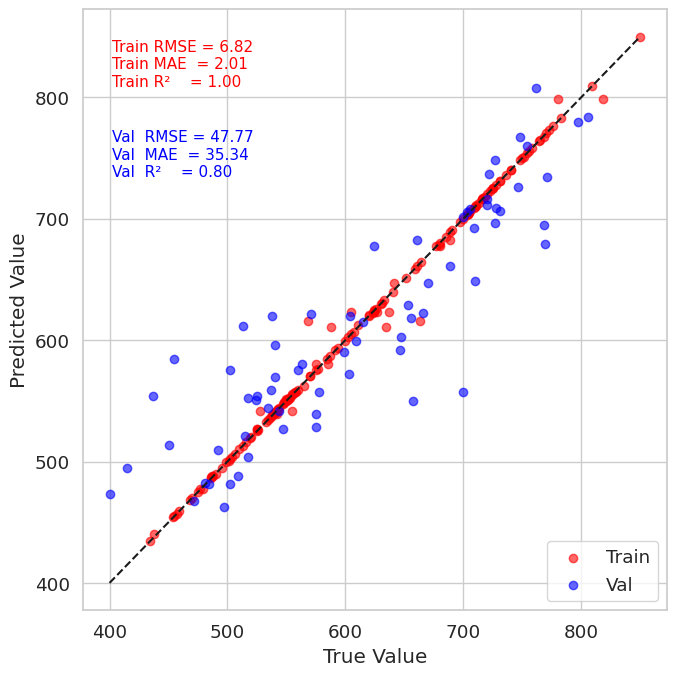

In [28]:
# モデル再構築
best_params = study.best_trial.params

model_lgb_best = lgb.LGBMRegressor(**best_params)
model_lgb_best.fit(autoscaled_X_train, y_train)

# 予測
y_train_pred = model_lgb_best.predict(autoscaled_X_train)
y_val_pred = model_lgb_best.predict(autoscaled_X_val)

# 可視化などに使うデータ整形
pred_train_df = pd.DataFrame({'true': y_train.values, 'pred': y_train_pred})
pred_val_df = pd.DataFrame({'true': y_val.values, 'pred': y_val_pred})

# 例：yyplot などに渡せる形式
yyplot(pred_train_df, pred_val_df)


### NN

In [41]:
# GPU set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [29]:
# yの標準化
y_scaler = StandardScaler()
autoscaled_y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
autoscaled_y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

In [42]:
# NN定義
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [43]:
# モデル構築
model_nn = MLPRegressor(input_dim=X.shape[1]).to(device)
# 損失関数
criterion = nn.MSELoss()
# 最適化関数
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-4)

In [44]:
# データセット定義
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [45]:
# Datasetに渡す（.valuesでnumpy化）
train_ds = RegressionDataset(autoscaled_X_train.values, autoscaled_y_train)
val_ds = RegressionDataset(autoscaled_X_val.values, autoscaled_y_val)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)

In [46]:
# 学習loop
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# 評価
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

Epoch   0 | Train Loss: 1.0447 | Val Loss: 1.0741
Epoch   1 | Train Loss: 0.4975 | Val Loss: 0.7513
Epoch   2 | Train Loss: 0.4904 | Val Loss: 0.5467
Epoch   3 | Train Loss: 0.4040 | Val Loss: 0.4807
Epoch   4 | Train Loss: 0.3704 | Val Loss: 0.4428
Epoch   5 | Train Loss: 0.3139 | Val Loss: 0.4241
Epoch   6 | Train Loss: 0.3257 | Val Loss: 0.3766
Epoch   7 | Train Loss: 0.2769 | Val Loss: 0.3565
Epoch   8 | Train Loss: 0.3194 | Val Loss: 0.3507
Epoch   9 | Train Loss: 0.2777 | Val Loss: 0.3316
Epoch  10 | Train Loss: 0.2944 | Val Loss: 0.3347
Epoch  11 | Train Loss: 0.2902 | Val Loss: 0.2833
Epoch  12 | Train Loss: 0.3082 | Val Loss: 0.2899
Epoch  13 | Train Loss: 0.2585 | Val Loss: 0.2839
Epoch  14 | Train Loss: 0.2437 | Val Loss: 0.3133
Epoch  15 | Train Loss: 0.1686 | Val Loss: 0.3178
Epoch  16 | Train Loss: 0.2285 | Val Loss: 0.3111
Epoch  17 | Train Loss: 0.2208 | Val Loss: 0.3119
Epoch  18 | Train Loss: 0.2697 | Val Loss: 0.3263
Epoch  19 | Train Loss: 0.2038 | Val Loss: 0.2887


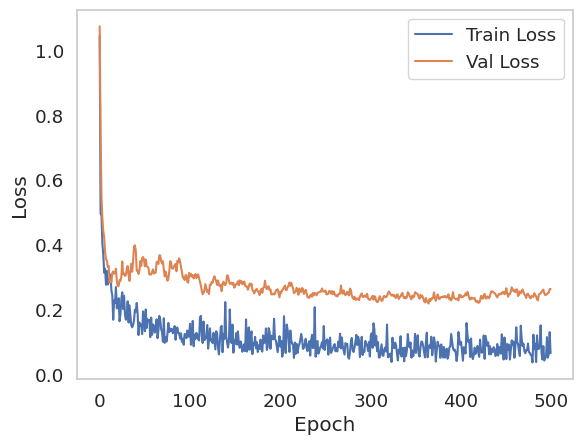

In [47]:
# 学習実行
n_epochs = 500

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = train(model_nn, train_dl, optimizer, criterion, device)
    val_loss = evaluate(model_nn, val_dl, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# 学習推移の可視化
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


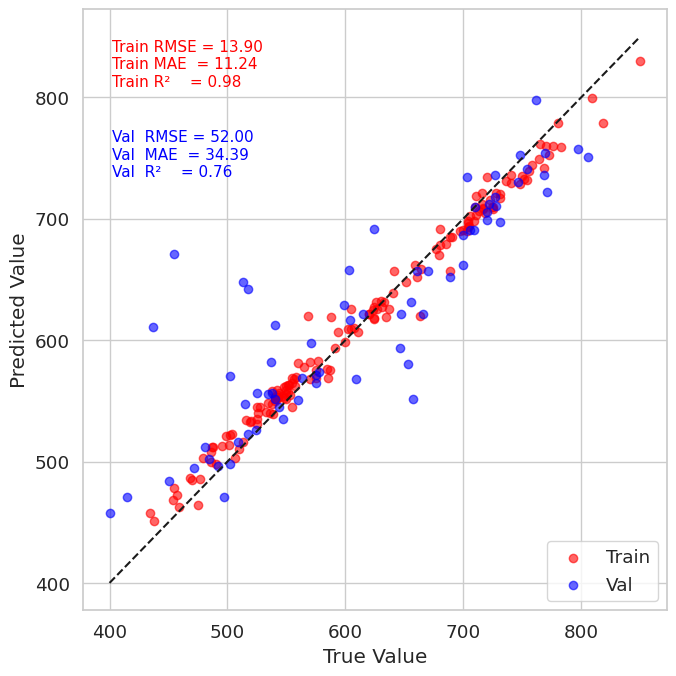

In [48]:
# 推論関数
def predict(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            preds.append(y_pred)
    return np.vstack(preds)

# 推論用（shuffleなし）DataLoaderを用意、train_dl を shuffle=True で作って学習したあと、その同じ train_dl で推論してしまうと、y_train と pred の順序が一致しなくなって、結果がズレます。
train_dl_eval = DataLoader(train_ds, batch_size=32, shuffle=False)
val_dl_eval = DataLoader(val_ds, batch_size=32, shuffle=False)

# 推論 & 逆変換
y_train_pred = y_scaler.inverse_transform(predict(model_nn, train_dl_eval, device))
y_val_pred = y_scaler.inverse_transform(predict(model_nn, val_dl_eval, device))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)


### NN+optuna

In [50]:
import optuna
import torch.nn.functional as F

def define_model(trial, input_dim):
    layers = []
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_dim = trial.suggest_int("hidden_dim", 64, 1024)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    activation_name = trial.suggest_categorical("activation", ["relu", "leaky_relu"])

    in_dim = input_dim
    for i in range(n_layers):
        layers.append(nn.Linear(in_dim, hidden_dim))
        if activation_name == "relu":
            layers.append(nn.ReLU())
        else:
            layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(dropout_rate))
        in_dim = hidden_dim

    layers.append(nn.Linear(in_dim, 1))
    return nn.Sequential(*layers)

def objective(trial):
    # データ準備（定義済み）
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

    model = define_model(trial, input_dim=X.shape[1]).to(device)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    # 学習ループ（簡略版）
    for epoch in range(30):
        model.train()
        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()

    # 検証
    val_loss = evaluate(model, val_dl, criterion, device)  # 前に定義した `evaluate` 関数を使う
    return val_loss


In [51]:
# 学習
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best trial:", study.best_trial.params)

[I 2025-06-24 20:23:11,382] A new study created in memory with name: no-name-49fba070-d7b0-4762-a0a1-00a8eb387324
[I 2025-06-24 20:23:11,969] Trial 0 finished with value: 0.6068054636319479 and parameters: {'batch_size': 32, 'n_layers': 2, 'hidden_dim': 419, 'dropout_rate': 0.025886234534654107, 'activation': 'relu', 'lr': 0.0023765072568657903, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6068054636319479.
[I 2025-06-24 20:23:12,244] Trial 1 finished with value: 0.18858200311660767 and parameters: {'batch_size': 128, 'n_layers': 2, 'hidden_dim': 681, 'dropout_rate': 0.32103728060842207, 'activation': 'leaky_relu', 'lr': 0.00045173615550112516, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.18858200311660767.
[I 2025-06-24 20:23:12,515] Trial 2 finished with value: 0.2159625142812729 and parameters: {'batch_size': 128, 'n_layers': 3, 'hidden_dim': 701, 'dropout_rate': 0.28839597564262115, 'activation': 'leaky_relu', 'lr': 0.0002703171093213999, 'optimizer': 'Adam'}. Best is 

Best trial: {'batch_size': 64, 'n_layers': 4, 'hidden_dim': 866, 'dropout_rate': 0.014213152628831521, 'activation': 'relu', 'lr': 0.00010227251730887781, 'optimizer': 'Adam'}


In [55]:
study.best_params

{'batch_size': 64,
 'n_layers': 4,
 'hidden_dim': 866,
 'dropout_rate': 0.014213152628831521,
 'activation': 'relu',
 'lr': 0.00010227251730887781,
 'optimizer': 'Adam'}

In [56]:
# モデル定義
class TunedMLP(nn.Module):
    def __init__(self, input_dim):
        super(TunedMLP, self).__init__()
        layers = []
        in_dim = input_dim
        hidden_dim = 866
        n_layers = 4
        dropout_rate = 0.014213152628831521
        activation = nn.ReLU()

        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [58]:
# DataLoader（batch_sizeも反映）
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

# モデル・損失関数・最適化手法
model_nn = TunedMLP(input_dim=X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.00010227251730887781)

# 学習
train_losses, val_losses = [], []
for epoch in range(1, 101):
    train_loss = train(model_nn, train_dl, optimizer, criterion, device)
    val_loss = evaluate(model_nn, val_dl, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 001 | Train Loss: 1.0053 | Val Loss: 1.2556
Epoch 002 | Train Loss: 0.8534 | Val Loss: 1.1243
Epoch 003 | Train Loss: 0.6713 | Val Loss: 0.9542
Epoch 004 | Train Loss: 0.5504 | Val Loss: 0.7729
Epoch 005 | Train Loss: 0.4306 | Val Loss: 0.6520
Epoch 006 | Train Loss: 0.3993 | Val Loss: 0.6116
Epoch 007 | Train Loss: 0.3427 | Val Loss: 0.5367
Epoch 008 | Train Loss: 0.3300 | Val Loss: 0.4557
Epoch 009 | Train Loss: 0.2402 | Val Loss: 0.4062
Epoch 010 | Train Loss: 0.2184 | Val Loss: 0.3435
Epoch 011 | Train Loss: 0.2186 | Val Loss: 0.2749
Epoch 012 | Train Loss: 0.1583 | Val Loss: 0.2425
Epoch 013 | Train Loss: 0.1558 | Val Loss: 0.2136
Epoch 014 | Train Loss: 0.1212 | Val Loss: 0.2121
Epoch 015 | Train Loss: 0.1289 | Val Loss: 0.2194
Epoch 016 | Train Loss: 0.1031 | Val Loss: 0.2020
Epoch 017 | Train Loss: 0.1000 | Val Loss: 0.2160
Epoch 018 | Train Loss: 0.0954 | Val Loss: 0.2123
Epoch 019 | Train Loss: 0.0848 | Val Loss: 0.2027
Epoch 020 | Train Loss: 0.0727 | Val Loss: 0.2189


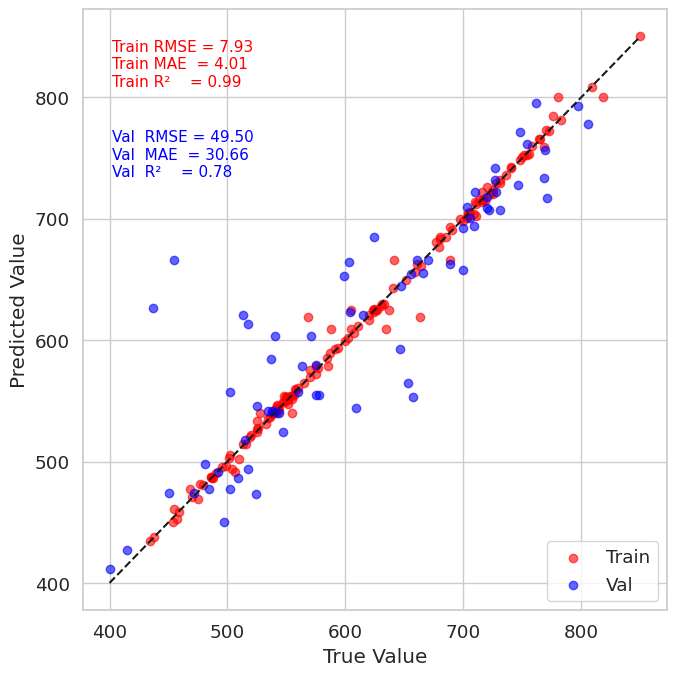

In [59]:
# 推論用DataLoader（shuffle=Falseで固定）
train_dl_eval = DataLoader(train_ds, batch_size=128, shuffle=False)
val_dl_eval = DataLoader(val_ds, batch_size=128, shuffle=False)

# 推論 & 逆変換
y_train_pred = y_scaler.inverse_transform(predict(model_nn, train_dl_eval, device))
y_val_pred = y_scaler.inverse_transform(predict(model_nn, val_dl_eval, device))

# 可視化データ作成
train_df = pd.DataFrame({'true': y_train.reset_index(drop=True), 'pred': y_train_pred.flatten()})
val_df = pd.DataFrame({'true': y_val.reset_index(drop=True), 'pred': y_val_pred.flatten()})

# 可視化
yyplot(train_df, val_df)
